<a href="https://colab.research.google.com/github/MDaniels-AI-Projects/Pneumonia-Classifier/blob/main/2_Pneumonia_Model_Train_and_Evaluate_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Check using GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep 18 22:59:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             57W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
#Check using high VRAM

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime motherfucker!')

Your runtime has 179.4 gigabytes of available RAM

You are using a high-RAM runtime motherfucker!


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Below code moves processed data into the sessions 'content' for quicker access to avoid bottlenecking problems while cpu moves imgs to gpu
# This is because previously it was training REALLY slowly, despite barely any A100 was used, meaning a bottleneck existed
# Apparently the bottleneck exists due to Google drive's system so it may run fine on another environment, like a home PC.
# This shows the important of running all your data first as if training takes too long, the whole project may not be practicable.
# The code ! is telling Collab to use a shell command. 'cp' means to copy files and -r means to copt the whole folder, not just part of it

print("Copying dataset from Google Drive to local Colab storage...")
!cp -r "/content/drive/MyDrive/Colab Notebooks/Udemy/DL in Medical Img/Pneumonia Imaging/Processed_Pneumonia_Data" "/content/processed_data/"
print("Dataset copied successfully!")

Copying dataset from Google Drive to local Colab storage...
Dataset copied successfully!


In [ ]:
#Lets check the local content folder:

!ls /content/

drive  processed_data  sample_data


## Introduction
In this notebook we will create and train the classifier on the chest x-ray dataset to classify whether an image shows signs of pneumonia or not

## Imports:

* torch and torchvision for model and dataloader creation
* transforms from torchvision for Data Augmentation and Normalization
* torchmetrics for easy metric computation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* tqdm for progress par when validating the model
* numpy for all kinds of stuff :)
* matplotlib for visualizing some images



In [ ]:
#We will use pytorch-lightning, which is a tool that organises and simplifys the training process.
#You may wish to dive deeper into changing various parameters, but we will use a simple model here.

!pip install torchmetrics pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 57.2 MB/s eta 0:00:00


In [ ]:
#We will need these packages.

import torch
import torchvision
from torchvision import transforms
import torchmetrics
import torchmetrics.classification as tm_cls
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#As we're USING A100 we want to reduce the precision to optimise the GPU tensor cores.
# For more, see: https://docs.pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html
torch.set_float32_matmul_precision('medium') # Or 'high' if you want to experiment further

First we create our dataset.
We can leverage the **DatasetFolder** from torchvision: It allows to simply pass a root directory and return return a dataset object with access to all files within the directory and the directory name as class label. <br />
We only need to define a loader function, **load_file**, which defines how the files shall be loaded.
This is very comfortable as we only have to load our previously stored numpy files.
Additionally, we need to define a list of file extensions (just "npy" in our case).

Finally we can pass a transformation sequence for Data Augmentation and Normalization.

We use:
* RandomResizedCrops which applies a random crop of the image and resizes it to the original image size (224x224)
* Random Rotations between -5 and 5 degrees
* Random Translation (max 5%)
* Random Scaling (0.9-1.1 of original image size)

In [ ]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [ ]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.0853271484375, 0.2340087890625),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.0853271484375], [0.2340087890625]),  # Use mean and std from preprocessing notebook
])




Finally, we create the train and val dataset and the corresponding data loaders.

Please adapt batch size and num_workers according to your hardware ressources.

In [ ]:
val_dataset = torchvision.datasets.DatasetFolder("/content/processed_data/stage_2_train_images/val", loader=load_file, extensions="npy", transform=val_transforms)
train_dataset = torchvision.datasets.DatasetFolder("/content/processed_data/stage_2_train_images/train", loader=load_file, extensions="npy", transform=train_transforms)

Let's inspect some random augmented train images. Due to there being a lot more 0s than 1s, it may need to be run a few times.

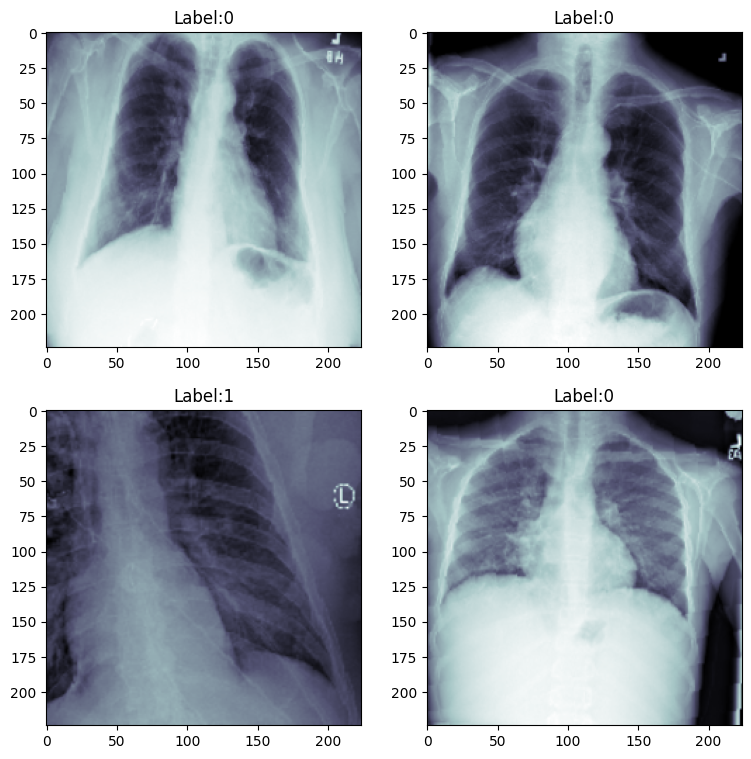

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9)) #Sets size of the images to look at.
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000) #Chooses random index to generate images
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")


In [ ]:
import torch.utils.data
# ... (your train_dataset and val_dataset definitions) ...

batch_size = 128  # Experiment with 32, 128, etc. if needed
num_workers = 4  # Experiment with 2 or 8 if needed

train_loader = torch.utils.data.DataLoader(train_dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")
print(f"Number of training batches per epoch: {len(train_loader)}")
print(f"Number of validation batches per epoch: {len(val_loader)}") # Added this for clarity

There are 24000 train images and 2684 val images
Number of training batches per epoch: 188
Number of validation batches per epoch: 21


In [ ]:
!nvidia-smi #Check GPU utilisation. 90% is GOOD. 50% is bad and therefore increase num workers or batch size. Run anytime

Thu Sep 18 23:56:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             57W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

The classes are imbalanced: There are more images without signs of pneumonia than with pneumonia.
There are multiple ways to deal with imbalanced datasets:
* Weighted Loss
* Oversampling
* Doing nothing :)

In this example, we will simply do nothing as this often yields the best results.
Buf feel free to play around with a weighted loss. A template to define a customized weighted loss function is provided below.

Oversampling will be shown in a later lecture.

In [ ]:
np.unique(train_dataset.targets, return_counts=True)

#0 means no pneumonia. 1 = pneumonia. Unique tells you how many images are unique, in this case 0 and 1.

(array([0, 1]), array([18593,  5407]))

In [ ]:
np.unique(val_dataset.targets, return_counts=True)

(array([0, 1]), array([2079,  605]))

## Model Creation in pytorch lightning

Each pytorch lightning model is defined by at least an initialization method, a **forward** function which defines the forward pass/prediction, a **training_step** which yields the loss and **configure_optimizers** to specify the optimization algorithm.

Additionally, we can use a **training_epoch_end** callback to compute overall dataset statistics and metrics such as accuracy.

Subsequently, we define the **validation_step**. The validation step performs more or less the same steps as the training step, however, on the validation data. In this case, pytorch lightning doesn't update the weights.
Again, we can use **validation_epoch_end** to compute overall dataset metrics.

No loops or manual weight updates are needed!<br />
Additionally, pl also handles device management.  Just pass the number of GPUS when creating the trainer.

**Now it is time to create the model** - We will use the ResNet18 network architecture.

As most of the torchvision models, the original ResNet expects a three channel input in **conv1**. <br />
However, our X-Ray image data has only one channel.
Thus we need to change the in_channel parameter from 3 to 1.

Additionally, we will change the last fully connected layer to have only one output as we have a binary class label.

### Optimizer and Loss
We use the **Adam** Optimizer with a learning rate of 0.0001 and the **BinaryCrossEntropy** Loss function.<br />
(In fact we use **BCEWithLogitsLoss** which directly accepts the raw unprocessed predicted values and computes the sigmoid activation function before applying Cross Entropy).
Feel free to pass a weight different from 1 to the Pneumonia model in order to use the weighted loss function.


In [ ]:
import torch.nn as nn
import torch
import torchvision
import torchmetrics
import pytorch_lightning as pl

class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()

        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        # simple accuracy computation
        # CORRECTED: The Accuracy metric now requires a 'task' argument.
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

        # NEW: Add F1-score metrics for both training and validation
        self.train_f1 = torchmetrics.F1Score(task="binary")
        self.val_f1 = torchmetrics.F1Score(task="binary")

        # NEW: Add Precision and Recall metrics
        self.train_precision = torchmetrics.Precision(task="binary")
        self.val_precision = torchmetrics.Precision(task="binary")
        self.train_recall = torchmetrics.Recall(task="binary")
        self.val_recall = torchmetrics.Recall(task="binary")


    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss

        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        # NEW: Log F1-score, Precision, and Recall in the training step
        self.log("Step Train F1", self.train_f1(torch.sigmoid(pred), label.int()))
        self.log("Step Train Precision", self.train_precision(torch.sigmoid(pred), label.int()))
        self.log("Step Train Recall", self.train_recall(torch.sigmoid(pred), label.int()))
        return loss


    # NEW HOOKS: Replaced training_epoch_end with on_train_epoch_end to fix the error.
    def on_train_epoch_end(self):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        self.log("Train F1", self.train_f1.compute())
        self.log("Train Precision", self.train_precision.compute())
        self.log("Train Recall", self.train_recall.compute())


    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)

        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        # NEW: Log F1-score, Precision, and Recall in the validation step
        self.log("Step Val F1", self.val_f1(torch.sigmoid(pred), label.int()))
        self.log("Step Val Precision", self.val_precision(torch.sigmoid(pred), label.int()))
        self.log("Step Val Recall", self.val_recall(torch.sigmoid(pred), label.int()))
        return loss

    # NEW HOOKS: Replaced validation_epoch_end with on_validation_epoch_end to fix the error.
    def on_validation_epoch_end(self):
        self.log("Val Acc", self.val_acc.compute())
        self.log("Val F1", self.val_f1.compute())
        self.log("Val Precision", self.val_precision.compute())
        self.log("Val Recall", self.val_recall.compute())


    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]


In [ ]:
model = PneumoniaModel() # Instanciate the model. Had to make changes from coursebook due to upgraded packages

We create a checkpoint callback which only stores the 10 best models based on the validation accuracy.

In [ ]:
#Early stopper Function

from pytorch_lightning.callbacks import EarlyStopping # Import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor='Val F1',   # Monitor your logged F1 score
    mode='max',         # You want to MAXIMIZE F1-score
    min_delta=0.001,    # Minimum change to be considered an improvement
    patience=10,        # Number of epochs to wait for improvement
    verbose=False,
)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath='/content/drive/MyDrive/Colab Notebooks/Udemy/DL in Medical Img/Pneumonia Imaging/model_checkpoints',
    # Update filename to reflect F1-score (optional, but good practice for clarity)
    # Use 'pm' as the abbreviation and include all desired metrics
    filename="pm-{epoch:02d}-F1={Val F1:.4f}-Acc={Val Acc:.4f}-Prec={Val Precision:.4f}-Rec={Val Recall:.4f}",
    monitor="Val F1", # <-- ADDED COMMA HERE
    mode="max",
    save_top_k=1,
    save_last=True
)

Trainer documentation: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

In [ ]:
# Making the trainer here.

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint # Make sure this is imported
from pytorch_lightning.callbacks import EarlyStopping # Make sure EarlyStopping is imported if not already

gpus = 1 # Keep this as 1 for a single GPU
trainer = pl.Trainer(
    accelerator='gpu',   # Specify that you want to use a GPU
    devices=gpus,        # Specify the number of GPU devices to use (which is 1)
    precision=16,        # REDUCED PRECISION TO GET BETTER GPU PERFORMANCE.
    logger=TensorBoardLogger(save_dir="./logs"),
    log_every_n_steps=1,
    callbacks=[checkpoint_callback, early_stop_callback], # <--- CHANGE THIS LINE!
    max_epochs=100,
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

#NOTE - IF RUNNING VERY SLOW MIGHT BE DUE TO BOTTLENECKING AS I/O SLOWLY SENDS DATA (NUM_WORKERS) TO THE GPU.
#THEREFORE BETTER TO MOVE PROCESSED DATA INTO CONTENT FOLDER FOR INSTANT ACCESS.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
4 | train_f1  | BinaryF1Score     | 0      | train
5 | val_f1    | BinaryF1Score     | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Evaluation

Let's evaluate our model!
At first, we load the latest checkpoint and send the model to the GPU, if possible.

In [ ]:
# This code block is designed to perform a final, detailed evaluation of the
# trained model on the entire validation (Val) dataset, to give
# you the comprehensive performance numbers that you can't get
# from the epoch-by-epoch training logs. In a nutshell, it takes the model you
# trained on the GPU, feeds it every single validation image one by one, and
# collects all the predictions and true labels. These collected lists are then
# used to calculate the final, authoritative metrics like accuracy, precision,
# and recall for the entire dataset.

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- ADD THIS LINE ---
model = model.to(device) # Move your model to the same device

preds = []  # Initialize an empty list to store model predictions.
labels = [] # Initialize an empty list to store true labels.

with torch.no_grad(): # Disable gradient calculations to save memory and speed up inference.
    for data, label in tqdm(val_dataset): # Iterate through the validation dataset with a progress bar.
        data = data.to(device).float().unsqueeze(0) # Move image data to the specified device, convert to float, and add a batch dimension.
        pred = torch.sigmoid(model(data)[0].cpu()) # Pass data through model, apply sigmoid, get first element, and move prediction to CPU.
        preds.append(pred) # Append the processed prediction to the predictions list.
        labels.append(label) # Append the true label to the labels list.
preds = torch.tensor(preds) # Convert the list of predictions to a PyTorch tensor.
labels = torch.tensor(labels).int() # Convert the list of true labels to a PyTorch integer tensor.

  0%|          | 0/2684 [00:00<?, ?it/s]

In [ ]:
# Assuming trainer.fit(model, train_loader, val_loader) has just finished running above

print("\n--- Running Final Evaluation ---")

# Step 1: Get the path to the best model checkpoint saved by the Trainer
best_model_path = trainer.checkpoint_callback.best_model_path

if best_model_path:
    print(f"Loading best model from: {best_model_path}")
    # Step 2: Load the best model from the checkpoint
    # Ensure you pass the correct weight for pos_weight if it's dynamic
    best_model = PneumoniaModel.load_from_checkpoint(
        best_model_path,
        weight=model.loss_fn.pos_weight.item() # Pass the pos_weight used in training
    )

    # Step 3: Put the best model in evaluation mode
    best_model.eval()

    # Step 4: Run a final validation pass using the loaded best model
    # Use the trainer to do this, as it handles devices and Dataloaders correctly
    print("\nRunning trainer.validate() on the best model...")
    final_val_results = trainer.validate(best_model, val_loader)

    # Step 5: Print the aggregated metrics from the validation results
    # final_val_results is a list of dictionaries, usually just one for single dataloader


    # Step 6: (Optional) If you still want to manually compute CM or other metrics
    # from raw predictions, you'd need to collect preds/labels from 'best_model'
    # but only if absolutely necessary. The trainer.validate() output is preferred.

    # Example of how you would get predictions from the best model if you need them for CM
    # This requires running through the val_loader again with the best_model
    # print("\nCollecting predictions for Confusion Matrix...")
    # best_preds = []
    # best_labels = []
    # with torch.no_grad():
    #     for x_ray, label in tqdm(val_loader):
    #         x_ray = x_ray.to(best_model.device) # Ensure data is on model's device
    #         logits = best_model(x_ray).squeeze(1)
    #         probs = torch.sigmoid(logits)
    #         best_preds.extend(probs.cpu().tolist())
    #         best_labels.extend(label.cpu().tolist())
    # best_preds_tensor = torch.tensor(best_preds)
    # best_labels_tensor = torch.tensor(best_labels).int()

    # Calculate and print Confusion Matrix for the best model
    # cm_best = torchmetrics.ConfusionMatrix(task='binary', num_classes=2)(best_preds_tensor, best_labels_tensor)
    # cm_threshed_best = torchmetrics.ConfusionMatrix(task='binary', num_classes=2, threshold=0.25)(best_preds_tensor, best_labels_tensor)
    # print(f"\nConfusion Matrix (Best Model, Threshold 0.5):\n {cm_best}")
    # print(f"Confusion Matrix (Best Model, Threshold 0.25):\n {cm_threshed_best}")

    if final_val_results:
        metrics = final_val_results[0]
        print("\nFinal Metrics from Best Model (from trainer.validate()):")
        print(f"Loss: {metrics.get('Val Loss', 'N/A')}") # Use .get to avoid KeyError
        print(f"Accuracy: {metrics.get('Val Acc', 'N/A')}")

        print(f"Precision: {metrics.get('Val Precision', 'N/A')}")
        print(f"Recall: {metrics.get('Val Recall', 'N/A')}")

        print(f"F1-Score: {metrics.get('Val F1', 'N/A')}")
    else:
        print("No validation results returned from trainer.validate().")

else:
    print("No best model path found from the trainer. Check if ModelCheckpoint callback was configured and training completed.")

# The plotting code you had below this evaluation section will now also use the 'best_model'
# if you rename your 'model' variable to 'best_model' in that section or ensure 'model' points to the trained one.
# For simplicity, for the plotting section, make sure 'model' variable refers to 'best_model'
# Example: model_for_plotting = best_model


--- Running Final Evaluation ---
Loading best model from: /content/drive/MyDrive/Colab Notebooks/Udemy/DL in Medical Img/Pneumonia Imaging/model_checkpoints/pm-epoch=18-F1=Val F1=0.6092-Acc=Val Acc=0.8371-Prec=Val Precision=0.0000-Rec=Val Recall=0.0000.ckpt


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Running trainer.validate() on the best model...


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Step Val Acc        │    0.8327123522758484     │
│        Step Val F1        │    0.18070204555988312    │
│    Step Val Precision     │    0.2352255880832672     │
│      Step Val Recall      │    0.14938083291053772    │
│          Val Acc          │    0.8327123522758484     │
│          Val F1           │     0.631060004234314     │
│         Val Loss          │    0.36807456612586975    │
│       Val Precision       │    0.6274510025978088     │
│        Val Recall         │    0.6347107291221619     │
└───────────────────────────┴───────────────────────────┘


Final Metrics from Best Model (from trainer.validate()):
Loss: 0.36807456612586975
Accuracy: 0.8327123522758484
Precision: 0.6274510025978088
Recall: 0.6347107291221619
F1-Score: 0.631060004234314


So, what do these numbers mean?

First thing to say is, if this model was used for real. The hospital would be bankrupt, closed down, and I would be in prison probably. The model is missing lots pneumonia, which is obviously morally (and legally) unacceptable.

The results suggest an imbalanced data set, where the positives are a minority. This makes training a bit difficult as the model does not have many positives to train from; hence why it misses lots of them.

Val Loss = This number measures the average "error" of your model on the validation dataset. The lower the number, the better the model is at making predictions that match the actual labels.

Accuracy = Percentage of validation images model classified correctly. An accuracy of 83.27% means it got about 8 out of every 10 images right. This is a good general metric, but a bit misleading with unbalanced data because it can still be making lots of mistakes when it matters.

Precision =  Of all the images model predicted as "pneumonia," what percentage were actually pneumonia? 63% means that model says an X-ray shows pneumonia, it's correct about two-thirds of the time. This is what causes "false alarms".

Recall = Of the images that actually had pneumonia, what percentage did the model correctly identify? 63.47% means it'ss finding about two-thirds of the total pneumonia cases in the validation set. 1/3 are being given the all clear incorrectly! NOT ACCEPTABLE

F1 Score = Nothing to do with race cars. This balances precision and recall and is useful to rate the model overall. This model is okay, but as said, it is missing a lot of disease.


Below lines up the model's prediction, and the 'truth'.

Notice how many false negatives, and false positives there are when you change the preds number. Play around with different values. Low makes the model "play it safe" so finds most images positives, where higher numbers does the opposite.

In [ ]:

#
#

binary_preds = (preds > 0.2).int()

# Count the number of predictions for each class.
num_preds_0 = (binary_preds == 0).sum().item()
num_preds_1 = (binary_preds == 1).sum().item()

print(f"Number of predicted '0's (Normal): {num_preds_0}")
print(f"Number of predicted '1's (Pneumonia): {num_preds_1}")

Number of predicted '0's (Normal): 0
Number of predicted '1's (Pneumonia): 2684


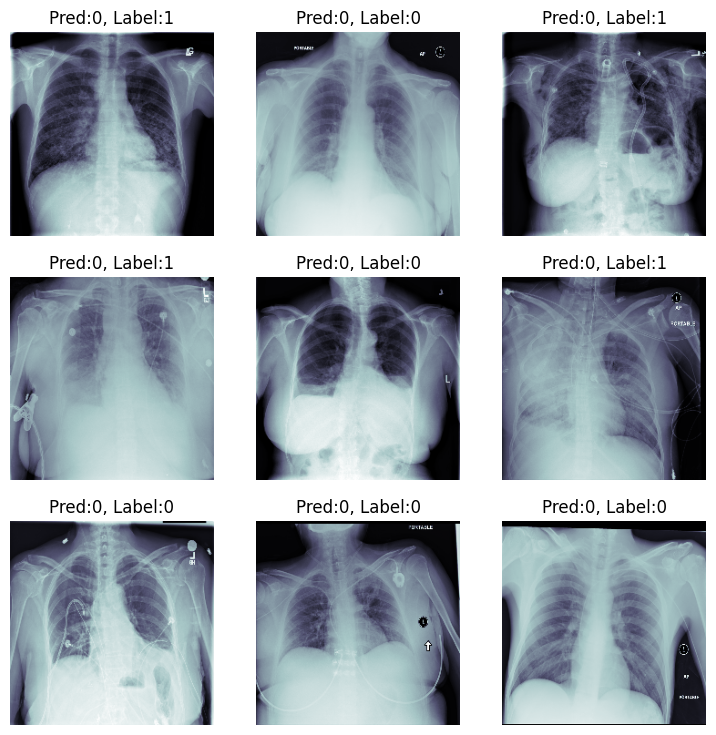

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")


What We Learned
Accuracy Can Be Misleading: Although the model's accuracy was 83%, this metric was deceiving. The model was simply correctly labeling the majority of "normal" (0) cases while missing most of the "pneumonia" (1) cases. This highlights a fundamental problem of unbalanced data and shows the importance of having a representative balance of labeled data.

The Prediction Bias: The model had a severe prediction bias, missing all the pneumonia cases in the validation set. This occurred because the prediction threshold was set too high. In future models, reducing this threshold would increase the model's sensitivity and its success in finding the minority class. This shows that a good machine learning engineer must experiment to find the "sweet spot," as it is impossible to be 100% accurate on real-world data.

F1-Scores Give a Better Overall Picture: The F1-score provided a more truthful view of the model's performance by balancing precision and recall, offering a much more reliable metric than accuracy for this type of problem.

Improving the Model
Overall, I just wanted to practice making a simple model on some publicly available data for my own learning. But going forward, I could improve the model by:

Adjusting the Prediction Threshold: We can experiment with this to find a better balance between precision (avoiding false alarms) and recall (finding all the true cases).

Implementing Class Weighting: We can tell the model to give more importance to the "pneumonia" class during training, forcing it to pay closer attention to these rare cases.

Resampling the Data: We could either oversample the minority class or undersample the majority class to create a more balanced dataset for the model to learn from.

Using Data Augmentation: This is a powerful process where you apply transformations like zooming, cropping, reversing, and changing contrast to your existing data. By doing so, you are essentially "reproducing" your data without needing to find more, which is especially useful for imbalanced datasets like this one.